In [5]:
import numpy as np
from scipy.io import loadmat
import json
import os
import cv2
import matplotlib.pyplot as plt
import random
import h5py
import tensorflow as tf

## Preparing the data
The images are .jpg files inside the images folder, while the joints/annotations for the images are located in a MATLAB file (.mat). We need to use the loadmat function to load the MATLAB file into the notebook. 



In [6]:
mpii_folder = "mpii"
dataset_folder = os.path.join(mpii_folder,"mpii_human_pose_v1")
image_folder = os.path.join(dataset_folder,"images")

In [17]:
mat = loadmat(os.path.join(dataset_folder,'mpii_human_pose_v1_u12_1.mat'))
mat = mat['RELEASE']

In [18]:
data = []

for i, (anno, train) in enumerate(
    zip(mat['annolist'][0,0][0], 
        mat['img_train'][0,0][0])
):
    img_name = anno['image']['name'][0,0][0]
    train = int(train)
    
    for annorect in anno['annorect']:
        if annorect.size < 1 or 'scale' not in str(annorect.dtype):
            continue
            
        for i, annorect in enumerate(annorect):
            if annorect['scale'][0].size < 1:
                continue
                
            scale = float(annorect['scale'][0, 0])
            x, y = annorect['objpos'][0, 0]
            x = int(x[0,0])
            y = int(y[0,0])
            
            if 'annopoints' in str(anno['annorect'].dtype):
                annopoints = annorect['annopoints']
                if annopoints['point'][0][0].size == 16:
                    points = annopoints[0,0]
                    joint_coords = {}
                    visible_joints = {}
                    
                    for coord in points[0][0]:
                        joint_coords[int(coord['id'][0,0])] = [float(coord['x'][0,0]), float(coord['y'][0,0])]
                        visible_joints[int(coord['id'][0,0])] = coord['is_visible'].item() if (coord['is_visible'].size > 0) else 0
                    
                    data.append({
                        'filename': img_name,
                        'joint_coords': joint_coords,
                        'visible_joints': visible_joints,
                        'for_training': train,
                        'approx_loc': {
                            'scale': scale,
                            'x': x,
                            'y': y,
                        }
                    })
            else:
                data.append({
                        'filename': img_name,
                        'for_training': train,
                        'approx_loc': {
                            'scale': scale,
                            'x': x,
                            'y': y,
                        }
                    })

In [19]:
output_json = os.path.join(mpii_folder,'data.json')
file = open(output_json, 'w')
json.dump(data, file, indent=2)

## Checkout the data
Let's show a random image and overlay the joints

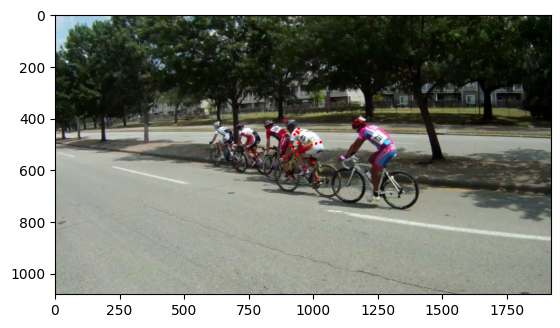

In [36]:
file = open(os.path.join(mpii_folder,'data.json'))
data = json.load(file)

def plot_joints(image_path, coordinates):
    image = cv2.imread(image_path)
    for joint in coordinates:
        cv2.circle(image, (int(joint[0]), int(joint[1])), 5, (0, 0, 255), -1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

# random.randrange(0,data.size)
example = data[271]
img_filename = example.get('filename')
joints = example.get('joint_coords')

joint_coords = []
for joint, coords in joints.items():
    joint_coords.append((coords[0], coords[1]))

plot_joints(os.path.join(image_folder,img_filename), joint_coords)

## Preprocessing the data
We will have to resize and crop the images to the same size, we will also save this into a HDF5 file as it handles large amounts of data very well

In [8]:
file = open(os.path.join(mpii_folder,'data.json'))
data = json.load(file)

In [7]:
def preprocess_image(img_path, objpos, scale, img_size=(128,128)):
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    
    crop_size = int(scale * 200) # Scale factor of 200px from Dataset
    x1, y1 = int(objpos[0] - crop_size // 2), int(objpos[1] - crop_size // 2)
    x2, y2 = x1 + crop_size, y1 + crop_size
    
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)
    
    cropped_img = img[y1:y2, x1:x2]
    resized_img = cv2.resize(cropped_img, img_size)
    
    scale_factor = img_size[0] / crop_size
    transform_params = (x1, y1, scale_factor)
    
    return resized_img, transform_params

def adjust_keypoints(keypoints, transform_params):
    x1, y1, scale_factor = transform_params
    adjusted_keypoints = np.zeros((16,2), dtype=np.float32)
    
    for key, (x, y) in keypoints.items():
        x_new = (x - x1) * scale_factor
        y_new = (y - y1) * scale_factor
        adjusted_keypoints[int(key)] = [x_new, y_new]
    
    return adjusted_keypoints

In [62]:
def create_dataset(name, for_training):
    num_samples = sum(1 for ann in data if ann['for_training'] == for_training)
    img_size = (128,128,3)
    
    with h5py.File(os.path.join(mpii_folder,name + '.h5'), 'w') as f:
        img_dataset = f.create_dataset("images", (num_samples, *img_size), dtype='uint8')
        keypoints_dataset = f.create_dataset("keypoints", (num_samples, 16, 2), dtype='float32')
        
        index = 0
        for ann in data:
            img_path = os.path.join(image_folder, ann['filename'])
            objpos = (ann['approx_loc']['x'], ann['approx_loc']['y'])
            scale = ann['approx_loc']['scale']
            
            preprocessed_img, transform_params = preprocess_image(img_path, objpos, scale)
            img_dataset[index] = preprocessed_img
            
            if ann['for_training'] == for_training:
                adjusted_keypoints = adjust_keypoints(ann['joint_coords'], transform_params)
                keypoints_dataset[index] = adjusted_keypoints
            
            index += 1
            if index >= num_samples: break
    
    print(name + ".h5 successfully created")

create_dataset('train_dataset', for_training=1)

test_dataset.h5 successfully created
train_dataset.h5 successfully created


## Load and Parse Data

In [5]:
file = open(os.path.join(mpii_folder,'data.json'))
data = json.load(file)

In [25]:
with h5py.File(os.path.join(mpii_folder, 'train_dataset.h5'), 'r') as f:
    images = np.array(f['images'])
    keypoints = np.array(f['keypoints'])

images = images.astype(np.float32) / 255.0
keypoints = keypoints / 128.0

In [26]:
num_samples = sum(1 for ann in data if ann['for_training'] == 1)
dataset = tf.data.Dataset.from_tensor_slices((images, keypoints)).shuffle(num_samples, seed=42).batch(32).prefetch(tf.data.AUTOTUNE)

In [28]:
from tensorflow import keras
from keras import layers

def build_simple(input_shape, num_keypoints=16):
    inputs = keras.Input(shape=input_shape)
    
    x = layers.Conv2D(32, (3,3), padding='same', activation="relu")(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Conv2D(64, (3,3), padding='same', activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Conv2D(128, (3,3), padding='same', activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(num_keypoints * 2, activation="sigmoid")(x)
    
    outputs = layers.Reshape((num_keypoints,2))(x)
    
    model = keras.Model(inputs, outputs, name="Simple_Keypoint_Detection")
    return model

input_shape = (128,128,3)
model = build_simple(input_shape)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

model.summary()

Model: "Simple_Keypoint_Detection"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 16, 2)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,490,336 (32.39 MB)

 Trainable params: 8,490,336 (32.39 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.fit(dataset, epochs=10)

Epoch 1/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 100s 158ms/step - loss: 0.0157 - mae: 0.0912
Epoch 2/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 98s 158ms/step - loss: 0.0120 - mae: 0.0782
Epoch 3/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 99s 159ms/step - loss: 0.0104 - mae: 0.0729
Epoch 4/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 100s 160ms/step - loss: 0.0086 - mae: 0.0662
Epoch 5/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 100s 160ms/step - loss: 0.0066 - mae: 0.0586
Epoch 6/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 99s 159ms/step - loss: 0.0051 - mae: 0.0514
Epoch 7/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 99s 159ms/step - loss: 0.0039 - mae: 0.0454
Epoch 8/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 99s 160ms/step - loss: 0.0033 - mae: 0.0410
Epoch 9/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 100s 160ms/step - loss: 0.0028 - mae: 0.0380
Epoch 10/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 99s 159ms/step - loss: 0.0025 - mae: 0.0357


In [31]:
model.save('model.keras')

## Let's work on the test data

In [9]:
model = tf.keras.models.load_model('model.keras')

file = open(os.path.join(mpii_folder,'data.json'))
data = json.load(file)

In [10]:
def preprocess_test_image(test_image):
    image, transform_params = preprocess_image(
        os.path.join(image_folder, test_image['filename']), 
        (test_image['approx_loc']['x'], test_image['approx_loc']['y']), 
        test_image['approx_loc']['scale']
    )
    
    image = image / 255.0
    return image, transform_params

In [11]:
testdata = []
for ann in data:
    if ann['for_training'] == 0:
        testdata.append(ann)

test_image = testdata[190]
test_image_location = os.path.join(image_folder, test_image['filename'])

input_image, transform_params = preprocess_test_image(test_image)
predictions = model.predict(np.expand_dims(input_image, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


In [12]:
def restore_keypoints(predictions, transform_params):
    x1, y1, scale_factor = transform_params
    keypoints = []

    for i in range(predictions.shape[1]):
        x_pred, y_pred = predictions[0, i]
        x_orig = (x_pred / scale_factor) + x1
        y_orig = (y_pred / scale_factor) + y1
        keypoints.append((x_orig, y_orig))

    return keypoints

restored_keypoints = restore_keypoints(predictions, transform_params)

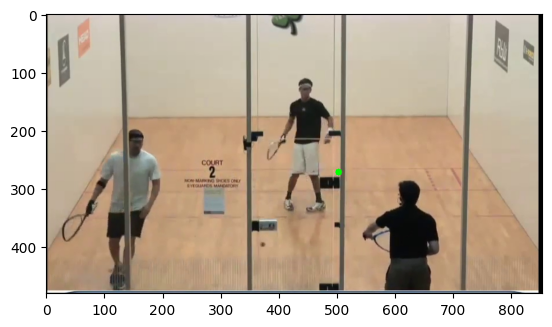

In [15]:
def visualize_predictions(img_path, keypoints):
    img = cv2.imread(img_path)
    for (x, y) in keypoints:
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            cv2.circle(img, (int(x), int(y)), 5, (0, 255, 0), -1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
visualize_predictions(test_image_location, restored_keypoints)